In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.utils import multi_gpu_model

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True

set_session(tf.Session(config=config))
print tf.__version__

Using TensorFlow backend.


1.8.0


In [3]:
from PIL import Image
import pandas as pd
import numpy as np
import keras
import re

print keras.__version__

2.1.6


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator

In [5]:
full_data_df = pd.read_hdf('../../data/full_data_common_animals.hdf', 'full_data_df')

In [6]:
full_data_df.head()

,caption,image,image_link,image_type,record_id,title
0,Collage of amphibians,../../data/img_common_animals/amphibians/tOSgy...,https://encrypted-tbn0.gstatic.com/images?q=tb...,png,tOSgylwuq-zi7M:,Amphibian - Wikipedia
1,Amphibians,../../data/img_common_animals/amphibians/BA01z...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,BA01zBROtA6QgM:,Amphibians | San Diego Zoo Animals & Plants
2,,../../data/img_common_animals/amphibians/TKxsc...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,TKxsciksiYOBcM:,amphibians-hero.jpg
3,Snake Head Pops Out of Frog's Maw in Mesmerizi...,../../data/img_common_animals/amphibians/mgGpN...,https://encrypted-tbn0.gstatic.com/images?q=tb...,,mgGpNhsvyK7htM:,Amphibians - 2018 News and Scientific Articles...
4,,../../data/img_common_animals/amphibians/a4k5F...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,a4k5Fu5KAIe9UM:,reticulated glass frog eggs.ngsversion.1465493...


In [7]:
def process_raw_text(x, tokenize=True, filter_symbols=True):
    x = x.lower()
    x = x.replace('.jpg', '')
    x = x.replace('.png', '')
    
    if tokenize:
        x = re.findall("[a-z0-9]+", x)
    else:
        x = re.sub("[^a-z0-9\ ]+", ' ', x)
    
#     x = x.replace(',', ' , ')
#     x = x.replace('?', ' ? ')
#     x = x.replace("'s ", " 's ")
#     x = x.replace(". ", " . ")
#     x = re.sub('\.{2,}', '', x)

#     if filter_symbols:
#         x = re.sub("[^a-z0-9\'\?\.]+", ' ', x)
    
#     if tokenize:
#         x = x.split(' ')
    
    return x


def jaccard_similarity(row):
    intersection = len(set(row['title_tokens']).intersection(row['caption_tokens']))
    union = len(set(row['title_tokens']).union(row['caption_tokens']))
    
    similarity = 1.0 * intersection / union
    
    return similarity


def get_effective_sample_text(row, sim_thresh=0.5):
    token_set = []
    title_tokens = row['title_tokens']
    caption_tokens = row['caption_tokens']
    
    if row['jaccard_sim'] > sim_thresh:
        if len(title_tokens) > len(caption_tokens):
            token_set.extend(title_tokens)
        else:
            token_set.extend(caption_tokens)
    else:
        token_set.extend(title_tokens)
        token_set.extend(caption_tokens)
        
    return token_set


def get_embedding_index(pre_trained_file, word_index):
    # Expected format is space separated.
    # First item is the word and succedding items are the elements of the vector
    embedding_index = {}
    
    with open(pre_trained_file) as fl:
        for line in fl:
            line = line.strip().split()
            word = line[0]
            vector = line[1:]
            if word in word_index:
                embedding_index[word] = np.array(vector, dtype=np.float32)
                
    return embedding_index

## Text data processing

In [8]:
sample_data = full_data_df[full_data_df.columns.drop(['image_link', 'image_type', 'record_id'])].loc[full_data_df.index]

sample_data = sample_data.drop_duplicates(['image'])

sample_data['title_tokens'] = sample_data['title'].map(process_raw_text)
sample_data['caption_tokens'] = sample_data['caption'].map(process_raw_text)

sample_data['jaccard_sim'] = sample_data.apply(jaccard_similarity, axis=1)
sample_data['tokens'] = sample_data.apply(get_effective_sample_text, axis=1)

sample_data = sample_data.drop(['caption', 'title', 'title_tokens', 'caption_tokens', 'jaccard_sim'], axis=1)

In [9]:
tokenizer = Tokenizer(num_words=10000, filters='', lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(sample_data['tokens'].map(lambda x: ' '.join(x)))

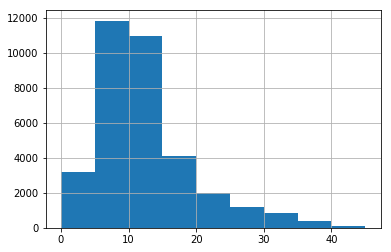

In [10]:
pd.Series([len(i) for i in tokenizer.texts_to_sequences(
    sample_data['tokens'].map(lambda x: ' '.join(x))
)]).hist(bins=range(0, 50, 5))

In [11]:
EMBEDDING_DIM = 300
MAXLEN = 15

In [12]:
sample_data['sequence'] = pad_sequences(
    tokenizer.texts_to_sequences(
        sample_data['tokens'].map(lambda x: ' '.join(x))
    ), maxlen=MAXLEN, padding='pre', truncating='post'
).tolist()

In [13]:
%%time
embeddings_index = get_embedding_index(
    pre_trained_file='/mnt/Datastore/WORK/pre-trained-models/glove.840B.300d.txt',
    word_index=tokenizer.word_index
)

CPU times: user 27.7 s, sys: 1.43 s, total: 29.1 s
Wall time: 30.2 s


In [14]:
%%time
# Keras reserves index 0 for masking
word_index = tokenizer.word_index

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.random.randn(len(word_index) + 1, EMBEDDING_DIM)
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 24418 word vectors.
CPU times: user 430 ms, sys: 12.1 ms, total: 442 ms
Wall time: 440 ms


In [15]:
sample_data['empty_sequence'] = sample_data.sequence.map(lambda x: sum(x) == 0)
sample_data = sample_data[~sample_data.empty_sequence]
sample_data.shape

In [17]:
sample_data.shape

(34514, 4)

## Image data processing

In [18]:
image_size = (150, 150, 3)

In [19]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=image_size)

# conv_base = ResNet50(
#     weights='imagenet',
#     pooling='max',
#     include_top=False,
#     input_shape=image_size
# )

In [20]:
def imread(name, flatten=False, mode=None, size=None):
    """
    Read an image from a file as an array.
    Parameters
    ----------
    name : str or file object
        The file name or file object to be read.
    flatten : bool, optional
        If True, flattens the color layers into a single gray-scale layer.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes for more
        details.
    Returns
    -------
    imread : ndarray
        The array obtained by reading the image.
    Notes
    -----
    `imread` uses the Python Imaging Library (PIL) to read an image.
    The following notes are from the PIL documentation.
    `mode` can be one of the following strings:
    * 'L' (8-bit pixels, black and white)
    * 'P' (8-bit pixels, mapped to any other mode using a color palette)
    * 'RGB' (3x8-bit pixels, true color)
    * 'RGBA' (4x8-bit pixels, true color with transparency mask)
    * 'CMYK' (4x8-bit pixels, color separation)
    * 'YCbCr' (3x8-bit pixels, color video format)
    * 'I' (32-bit signed integer pixels)
    * 'F' (32-bit floating point pixels)
    PIL also provides limited support for a few special modes, including
    'LA' ('L' with alpha), 'RGBX' (true color with padding) and 'RGBa'
    (true color with premultiplied alpha).
    When translating a color image to black and white (mode 'L', 'I' or
    'F'), the library uses the ITU-R 601-2 luma transform::
        L = R * 299/1000 + G * 587/1000 + B * 114/1000
    When `flatten` is True, the image is converted using mode 'F'.
    When `mode` is not None and `flatten` is True, the image is first
    converted according to `mode`, and the result is then flattened using
    mode 'F'.
    """

    im = Image.open(name)
    
    if size is not None:
        im = im.resize(size)
        
    return fromimage(im, flatten=flatten, mode=mode)


def fromimage(im, flatten=False, mode=None):
    """
    Return a copy of a PIL image as a numpy array.
    Parameters
    ----------
    im : PIL image
        Input image.
    flatten : bool
        If true, convert the output to grey-scale.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes of the
        `imread` docstring for more details.
    Returns
    -------
    fromimage : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    if not Image.isImageType(im):
        raise TypeError("Input is not a PIL image.")

    if mode is not None:
        if mode != im.mode:
            im = im.convert(mode)
    elif im.mode == 'P':
        # Mode 'P' means there is an indexed "palette".  If we leave the mode
        # as 'P', then when we do `a = array(im)` below, `a` will be a 2-D
        # containing the indices into the palette, and not a 3-D array
        # containing the RGB or RGBA values.
        if 'transparency' in im.info:
            im = im.convert('RGBA')
        else:
            im = im.convert('RGB')

    if flatten:
        im = im.convert('F')
    elif im.mode == '1':
        # Workaround for crash in PIL. When im is 1-bit, the call array(im)
        # can cause a seg. fault, or generate garbage. See
        # https://github.com/scipy/scipy/issues/2138 and
        # https://github.com/python-pillow/Pillow/issues/350.
        #
        # This converts im from a 1-bit image to an 8-bit image.
        im = im.convert('L')

    a = np.array(im)
    return a


def recast_array_to_image(float_array):
    uint_array = (float_array * 255 / np.max(float_array)).astype('uint8')

    return Image.fromarray(uint_array)


image_cache = {}

def load_image(path, size=image_size[:-1], as_float=True):
    if path not in image_cache:
        
        im = imread(path, size=size)
        
        if as_float:
            im = im.astype(np.float32)
            
        image_cache[path] = im
        
    return image_cache[path]

In [21]:
%%time
image_datagen = ImageDataGenerator(
    rescale=1./255
)

sample_data['image_array'] = conv_base.predict(
    image_datagen.flow(
        np.stack(sample_data['image'].map(load_image)),
        batch_size=sample_data.shape[0], shuffle=False
    ).next()
).tolist()

CPU times: user 1min 42s, sys: 27.9 s, total: 2min 10s
Wall time: 2min 12s


In [22]:
def pretrain_model_image_generator(image_data, batch_size):
    image_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Exploit image_datagen for dynamic perturbation of the data    
    image_data = image_datagen.flow(
        image_data,
        batch_size=len(image_data), shuffle=False
    ).next()
    
    image_data = conv_base.predict(image_data)
    
    for i in range(0, len(image_data) // batch_size):
        yield image_data[i * batch_size: (i + 1) * batch_size]


def dataset_generator(dataset, batch_size=32, shuffle=True, negative_fold=1):
    index = np.array(dataset.index.values)  # Interestingly, data gets shuffled if we don't use np.array to create a new object!
    full_batch_size = batch_size * (negative_fold + 1)

    batch_index = []
    while True:
        
        if shuffle:
            np.random.shuffle(index)

        for i in index:
            if len(batch_index) < batch_size:
                batch_index.append(i)

            else:
                positive_df = dataset.loc[batch_index]
                
                batch_image_data = np.stack(positive_df['image_array'])
                positive_text_data = np.stack(positive_df['sequence'])
                
                if negative_fold:
                    batch_image_data = np.vstack([batch_image_data] * (negative_fold + 1))

                    negative_index = np.random.choice(index, size=batch_size * negative_fold, replace=True)
                    negative_text_data = np.stack(dataset.loc[negative_index]['sequence'])
                
                    text_data = np.vstack([positive_text_data, negative_text_data])
                else:
                    text_data = positive_text_data
                
                label = np.zeros(full_batch_size)
                label[:batch_size] = 1
                
                ix = np.array(range(full_batch_size))
                if shuffle:
                    ix = np.random.choice(ix, size=full_batch_size, replace=False)
                
                batch_index = []
                yield [text_data[ix], batch_image_data[ix]], label[ix]
#                 yield [text_data[ix], conv_base.predict(batch_image_data[ix])], label[ix]

In [23]:
sample_data.head()

,image,tokens,sequence,empty_sequence,image_array
0,../../data/img_common_animals/amphibians/tOSgy...,"[amphibian, wikipedia, collage, of, amphibians]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 267, 114, 6430,...",False,"[[[2.54179358482, 0.0, 0.338100135326, 0.08324..."
1,../../data/img_common_animals/amphibians/BA01z...,"[amphibians, san, diego, zoo, animals, plants,...","[0, 0, 0, 0, 0, 0, 0, 0, 67, 303, 437, 34, 45,...",False,"[[[0.293233424425, 0.0, 0.0, 0.473557472229, 0..."
2,../../data/img_common_animals/amphibians/TKxsc...,"[amphibians, hero]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 67, 1832]",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0670852661133, 0.0, 0..."
3,../../data/img_common_animals/amphibians/mgGpN...,"[amphibians, 2018, news, and, scientific, arti...","[67, 335, 85, 4, 783, 1170, 9, 208, 164, 126, ...",False,"[[[0.0, 0.0, 0.304383337498, 0.0, 0.2095175385..."
4,../../data/img_common_animals/amphibians/a4k5F...,"[reticulated, glass, frog, eggs, ngsversion, 1...","[0, 0, 0, 0, 0, 0, 0, 8869, 1643, 73, 1569, 15...",False,"[[[0.672548413277, 0.0, 0.0, 0.0155125111341, ..."


In [24]:
data_gen = dataset_generator(sample_data, batch_size=32, shuffle=True, negative_fold=2)

In [25]:
%%time
q = data_gen.next()

CPU times: user 10.9 ms, sys: 7.85 ms, total: 18.8 ms
Wall time: 22.6 ms


In [26]:
from keras.layers import Input, GRU, Bidirectional, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, LeakyReLU

In [27]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=True
# )(text_model_input)

# text_gru = GRU(64, return_sequences=True)(text_embedding)
# text_gru = GRU(64, return_sequences=False)(text_gru)
# text_dense = Dense(128, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# text_dense = Dense(128, activation='relu')(text_dense)
# text_dense = Dropout(0.3)(text_dense)
# text_model_output = Dense(100, activation='tanh')(text_dense)
# # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)

# image_model_input = Input(shape=(8, 8, 512))
# image_conv = Conv2D(64, 2)(image_model_input)
# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# # image_conv = Conv2D(64, 2)(image_pool)
# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# image_flatten = Flatten()(image_pool)
# image_dense = Dense(128, activation='relu')(image_flatten)
# image_dense = Dropout(0.3)(image_dense)
# image_model_output = Dense(100, activation='tanh')(image_dense)
# # image_model_output = LeakyReLU(alpha=0.2)(image_model_output)


# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [28]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=True
# )(text_model_input)

# text_gru = GRU(128, return_sequences=True)(text_embedding)
# text_gru = GRU(64)(text_gru)
# text_dense = Dense(300, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# # text_dense = keras.layers.Reshape((300 * 30,), input_shape=(30, 300))(text_dense)
# text_dense = Dense(256, activation='relu')(text_dense)
# text_dense = Dropout(0.5)(text_dense)
# text_model_output = Dense(100)(text_dense)
# text_model_output = LeakyReLU(alpha=0.2)(text_model_output)

# image_model_input = Input(shape=(2048,))
# # image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

# # image_conv = Conv2D(128, 2)(image_model_input)
# # image_conv = Conv2D(64, 2)(image_conv)
# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# # image_conv = Conv2D(32, 2)(image_pool)

# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# # image_flatten = Flatten()(image_pool)
# image_dense = Dense(300, activation='relu')(image_model_input)
# image_dense = Dropout(0.3)(image_dense)
# image_model_output = Dense(100)(image_dense)
# image_model_output = LeakyReLU(alpha=0.2)(image_model_output)


# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [62]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=False
# )(text_model_input)

# text_gru = Bidirectional(GRU(64, return_sequences=False))(text_embedding)
# # text_gru = Bidirectional(GRU(64))(text_gru)
# text_dense = Dense(300, activation='relu')(text_gru)
# text_dense = Dropout(0.2)(text_dense)
# text_model_output = Dense(200, activation='tanh')(text_dense)

# # text_gru = GRU(64, return_sequences=True)(text_embedding)
# # text_gru = GRU(64, return_sequences=False)(text_gru)
# # text_dense = Dense(128, activation='relu')(text_gru)
# # text_dense = Dropout(0.3)(text_dense)
# # text_dense = Dense(128, activation='relu')(text_dense)
# # text_dense = Dropout(0.3)(text_dense)
# # text_model_output = Dense(100, activation='tanh')(text_dense)
# # # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)


# image_model_input = Input(shape=(4, 4, 512))
# # image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

# image_conv = Conv2D(64, 2)(image_model_input)
# # image_conv = Conv2D(64, 2)(image_conv)
# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# # image_conv = Conv2D(32, 2)(image_pool)

# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# image_flatten = Flatten()(image_pool)
# image_dense = Dense(300, activation='relu')(image_flatten)
# image_dense = Dropout(0.3)(image_dense)
# # image_cat = keras.layers.concatenate([image_dense, image_flatten])

# image_model_output = Dense(200, activation='tanh')(image_flatten)


# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [63]:
# text_model_input = keras.layers.Input(shape=(MAXLEN,))
# text_embedding = keras.layers.Embedding(
#     input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
#     weights=[embedding_matrix],
#     trainable=False
# )(text_model_input)

# text_gru = Bidirectional(GRU(64, return_sequences=False))(text_embedding)
# # text_gru = Bidirectional(GRU(64))(text_gru)
# text_dense = Dense(300, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)

# text_dense2 = Dense(200, activation='relu')(text_dense)
# text_dense2 = Dropout(0.2)(text_dense2)

# text_dense3 = Dense(100, activation='relu')(text_dense2)
# text_dense3 = Dropout(0.1)(text_dense3)

# full_text_dense = text_dense  # keras.layers.concatenate([text_dense, text_dense2, text_dense3])
# text_model_output = Dense(200, activation='tanh')(full_text_dense)

# # text_gru = GRU(64, return_sequences=True)(text_embedding)
# # text_gru = GRU(64, return_sequences=False)(text_gru)
# # text_dense = Dense(128, activation='relu')(text_gru)
# # text_dense = Dropout(0.3)(text_dense)
# # text_dense = Dense(128, activation='relu')(text_dense)
# # text_dense = Dropout(0.3)(text_dense)
# # text_model_output = Dense(100, activation='tanh')(text_dense)
# # # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)


# image_model_input = Input(shape=(4, 4, 512))
# # image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

# image_conv = Conv2D(64, 2)(image_model_input)
# # image_conv = Conv2D(64, 2)(image_conv)
# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# # image_conv = Conv2D(32, 2)(image_pool)

# # image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
# image_flatten = Flatten()(image_pool)

# image_dense = Dense(300, activation='relu')(image_flatten)
# image_dense = Dropout(0.3)(image_dense)

# image_dense2 = Dense(200, activation='relu')(image_dense)
# image_dense2 = Dropout(0.2)(image_dense2)

# image_dense3 = Dense(100, activation='relu')(image_dense2)
# image_dense3 = Dropout(0.1)(image_dense3)

# full_image_dense = image_dense  # keras.layers.concatenate([image_dense, image_dense2, image_dense3])

# image_model_output = Dense(200, activation='tanh')(full_image_dense)

# target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
# target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

# ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

# ImageSearchModel.compile(
#     optimizer='adam',
#     loss='binary_crossentropy'
# )

In [102]:
text_model_input = keras.layers.Input(shape=(MAXLEN,))
text_embedding = keras.layers.Embedding(
    input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False
)(text_model_input)

text_gru = Bidirectional(GRU(64, return_sequences=False))(text_embedding)
# text_gru = Bidirectional(GRU(64))(text_gru)
text_dense = Dense(300, activation='relu')(text_gru)
text_dense = Dropout(0.3)(text_dense)

text_dense2 = Dense(200, activation='relu')(text_dense)
text_dense2 = Dropout(0.2)(text_dense2)

text_dense3 = Dense(100, activation='relu')(text_dense2)
text_dense3 = Dropout(0.1)(text_dense3)

full_text_dense = text_dense  # keras.layers.concatenate([text_dense, text_dense2, text_dense3])
text_model_output = Dense(200, activation='tanh')(full_text_dense)

# text_gru = GRU(64, return_sequences=True)(text_embedding)
# text_gru = GRU(64, return_sequences=False)(text_gru)
# text_dense = Dense(128, activation='relu')(text_gru)
# text_dense = Dropout(0.3)(text_dense)
# text_dense = Dense(128, activation='relu')(text_dense)
# text_dense = Dropout(0.3)(text_dense)
# text_model_output = Dense(100, activation='tanh')(text_dense)
# # text_model_output = LeakyReLU(alpha=0.2)(text_model_output)


image_model_input = Input(shape=(4, 4, 512))
# image_model_shaped = keras.layers.Reshape((64, 64, 2), input_shape=(4, 4, 512))(image_model_input)

image_conv = Conv2D(64, 2)(image_model_input)
# image_conv = Conv2D(64, 2)(image_conv)
image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)

# image_conv = Conv2D(32, 2)(image_pool)

# image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
image_flatten = Flatten()(image_pool)

# image_dense = Dense(300, activation='relu')(image_flatten)
# image_dense = Dropout(0.3)(image_dense)

# image_dense2 = Dense(200, activation='relu')(image_dense)
# image_dense2 = Dropout(0.2)(image_dense2)

# image_dense3 = Dense(100, activation='relu')(image_dense2)
# image_dense3 = Dropout(0.1)(image_dense3)

# full_image_dense = image_dense  # keras.layers.concatenate([image_dense, image_dense2, image_dense3])

image_model_output = Dense(200, activation='tanh')(image_flatten)  # full_image_dense)

target_ouput = keras.layers.merge([text_model_output, image_model_output], mode='cos')
target_ouput = keras.layers.Reshape((1,), input_shape=(1, 1))(target_ouput)

ImageSearchModel = keras.models.Model(inputs=[text_model_input, image_model_input], outputs=[target_ouput])

ImageSearchModel.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [103]:
ImageModel = keras.models.Model(inputs=[image_model_input], outputs=[image_model_output])
TextModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_output])

In [104]:
ImageSearchModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 15, 300)      9454800     input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 4, 4, 512)    0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 128)          140160      embedding_7[0][0]                
__________________________________________________________________________________________________
conv2d_7 (

In [105]:
full_data_df.shape

(34889, 6)

In [106]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=1)

Epoch 1/1
1090/1090 [==============================] - 27s 25ms/step - loss: 0.6009
CPU times: user 45.5 s, sys: 2.1 s, total: 47.6 s
Wall time: 27.9 s


In [107]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=10)

Epoch 1/10
1090/1090 [==============================] - 26s 23ms/step - loss: 0.5591
Epoch 2/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.5382
Epoch 3/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.5213
Epoch 4/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.5053
Epoch 5/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4960
Epoch 6/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4952
Epoch 7/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4819
Epoch 8/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4746
Epoch 9/10
1090/1090 [==============================] - 26s 23ms/step - loss: 0.4623
Epoch 10/10
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4708
CPU times: user 7min 8s, sys: 22.3 s, total: 7min 30s
Wall time: 4min 14s


In [108]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=100)

Epoch 1/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.4593
Epoch 2/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4327
Epoch 3/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4445
Epoch 4/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4282
Epoch 5/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4184
Epoch 6/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4510
Epoch 7/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4070
Epoch 8/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.4079
Epoch 9/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4313
Epoch 10/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.3957
Epoch 11/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.3897
Epoch 12/100
1090/1090 [============================

1090/1090 [==============================] - 25s 23ms/step - loss: 0.2035
Epoch 95/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.2028
Epoch 96/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.2033
Epoch 97/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.2019
Epoch 98/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.2014
Epoch 99/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.2026
Epoch 100/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.2029
CPU times: user 1h 11min 38s, sys: 3min 48s, total: 1h 15min 26s
Wall time: 42min 35s


In [109]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=100)

Epoch 1/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.2001
Epoch 2/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.2013
Epoch 3/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.2017
Epoch 4/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.2023
Epoch 5/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.1989
Epoch 6/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.1986
Epoch 7/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1980
Epoch 8/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1988
Epoch 9/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1982
Epoch 10/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1993
Epoch 11/100
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1979
Epoch 12/100
1090/1090 [============================

1090/1090 [==============================] - 26s 23ms/step - loss: 0.1830
Epoch 95/100
1090/1090 [==============================] - 26s 23ms/step - loss: 0.1815
Epoch 96/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.1823
Epoch 97/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.1796
Epoch 98/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.1899
Epoch 99/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.1843
Epoch 100/100
1090/1090 [==============================] - 26s 24ms/step - loss: 0.1826
CPU times: user 1h 11min 39s, sys: 3min 46s, total: 1h 15min 25s
Wall time: 42min 33s


In [ ]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=300)

Epoch 1/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4753
Epoch 2/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4683
Epoch 3/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4474
Epoch 4/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4415
Epoch 5/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4486
Epoch 6/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4407
Epoch 7/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4468 2s -
Epoch 8/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4259
Epoch 9/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4260
Epoch 10/300
1090/1090 [==============================] - 26s 24ms/step - loss: 0.4158
Epoch 11/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.4057
Epoch 12/300
1090/1090 [=======================

1090/1090 [==============================] - 25s 23ms/step - loss: 0.1807
Epoch 189/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1801
Epoch 190/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1804
Epoch 191/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1823
Epoch 192/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1797
Epoch 193/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1796
Epoch 194/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1795
Epoch 195/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1815
Epoch 196/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1802
Epoch 197/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1799
Epoch 198/300
1090/1090 [==============================] - 26s 23ms/step - loss: 0.1793
Epoch 199/300
1090/1090 [=====================

1090/1090 [==============================] - 25s 23ms/step - loss: 0.1739
Epoch 282/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1919
Epoch 283/300
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1754
Epoch 284/300
 606/1090 [===============>..............] - ETA: 11s - loss: 0.1733 ETA: 11s - 

In [70]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=1)

Epoch 1/1
1090/1090 [==============================] - 25s 23ms/step - loss: 0.1734
CPU times: user 42.5 s, sys: 2.46 s, total: 44.9 s
Wall time: 25.3 s


In [174]:
%%time
ImageSearchModel.fit_generator(data_gen, steps_per_epoch=full_data_df.shape[0] // 32, epochs=100)

Epoch 1/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1804
Epoch 2/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.2166
Epoch 3/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1776
Epoch 4/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1778
Epoch 5/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1763
Epoch 6/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1746
Epoch 7/100
1090/1090 [==============================] - 23s 21ms/step - loss: 0.1772
Epoch 8/100
1090/1090 [==============================] - 23s 22ms/step - loss: 0.1760
Epoch 9/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1757
Epoch 10/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1790
Epoch 11/100
1090/1090 [==============================] - 24s 22ms/step - loss: 0.1820
Epoch 12/100
1090/1090 [============================

In [71]:
# %%time
# predict_image_datagen = ImageDataGenerator(
#     rescale=1./255,
# )

# image_data = sample_data['image'].map(load_image)
# image_data = np.stack(image_data)

# # Exploit image_datagen for dynamic perturbation of the data
# image_data = predict_image_datagen.flow(
#     image_data,
#     batch_size=sample_data.shape[0], shuffle=False
# ).next()

# image_embeddings = ImageModel.predict(conv_base.predict(image_data))

In [72]:
sample_data.columns

Index([u'image', u'tokens', u'sequence', u'empty_sequence', u'image_array'], dtype='object')

In [110]:
%%time
image_embeddings = ImageModel.predict(np.stack(sample_data['image_array'].values))

CPU times: user 6.66 s, sys: 677 ms, total: 7.33 s
Wall time: 7.07 s


In [111]:
image_embeddings.shape

(34514, 200)

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

In [119]:
seq = pad_sequences(
    tokenizer.texts_to_sequences(
        [' '.join(process_raw_text('dogs and cats'))]
    ), maxlen=MAXLEN, padding='pre', truncating='post'
)
query_vector = TextModel.predict(
    seq
)

seq

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 196,
          4, 152]], dtype=int32)

In [120]:
%%time
res = cosine_similarity(image_embeddings, query_vector)

CPU times: user 26.5 ms, sys: 0 ns, total: 26.5 ms
Wall time: 14.6 ms


In [121]:
top_ix = res[:, 0].argsort()[::-1][:10]
print(res[:, 0][top_ix])
print(top_ix)

[0.9788549  0.97482795 0.97208154 0.9720109  0.97136825 0.9711601
 0.97114146 0.9707796  0.97065145 0.9703762 ]
[ 1059   818   955  1231   819   843   719   851   803 30195]


In [122]:
sample_data.iloc[top_ix]

,image,tokens,sequence,empty_sequence,image_array
1063,../../data/img_common_animals/dog/1zmBaHGEtEiS...,"[best, natural, dog, foods, nutro, brands, foo...","[0, 0, 0, 0, 0, 0, 128, 248, 52, 1504, 2912, 2...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
822,../../data/img_common_animals/dog/Z5BLm3b2gM3b...,"[google, japan, now, has, street, view, from, ...","[0, 0, 1528, 624, 366, 134, 2105, 346, 31, 3, ...",False,"[[[0.521450340748, 0.0, 0.0505228042603, 0.060..."
959,../../data/img_common_animals/dog/5qDHBS8D1d_a...,"[free, images, nature, animal, female, educati...","[35, 38, 103, 24, 214, 825, 334, 644, 35, 38, ...",False,"[[[0.352080762386, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1239,../../data/img_common_animals/dog/UGCDhzgS1N0-...,"[dogs, coryc, me, bring, your, dog, to, our, w...","[0, 0, 0, 0, 0, 0, 0, 0, 196, 354, 1548, 75, 5...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
823,../../data/img_common_animals/dog/qA8QoFA79CAd...,"[image, shutterstock, com, z, stock, photo, be...","[0, 0, 0, 0, 0, 0, 42, 464, 25, 555, 53, 21, 4...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0249029844999, 0.0, 0..."
847,../../data/img_common_animals/dog/nhUfb07U8Vs_...,"[sponsor, a, guide, dog, puppy, guide, dogs, i...","[4772, 3, 215, 52, 707, 215, 196, 42, 2, 3, 70...",False,"[[[0.17254948616, 0.0, 0.0, 0.0, 0.25554394722..."
723,../../data/img_common_animals/dog/rHT5kn7li-uh...,"[how, personality, affects, a, person, s, chan...","[0, 0, 0, 30, 1224, 4765, 3, 1502, 7, 3794, 2,...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
855,../../data/img_common_animals/dog/Gg_6M2RlOsO_...,"[long, lived, dog, breeds, in, pictures, labra...","[0, 0, 0, 0, 0, 151, 2107, 52, 240, 5, 36, 4, ...",False,"[[[0.168662905693, 0.0, 0.824302613735, 0.0, 0..."
807,../../data/img_common_animals/dog/PpQj-MxGAU_R...,"[adoptable, dogs, dog, tales, rescue, and, san...","[0, 0, 0, 0, 0, 0, 0, 5202, 196, 52, 3057, 388...",False,"[[[0.354236364365, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
30551,../../data/img_common_animals/lynx/zDo_-cfmzEP...,"[lynx, pads, lynx]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 8236,...",False,"[[[0.589346647263, 0.0, 0.458634674549, 0.0, 0..."


In [123]:
import pylab as plt

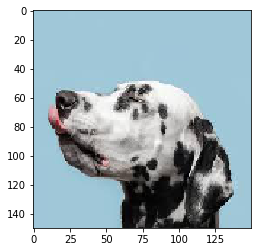

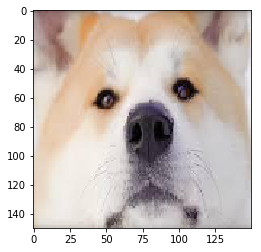

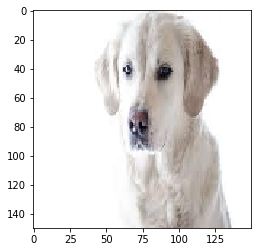

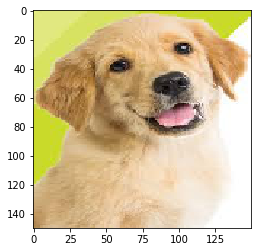

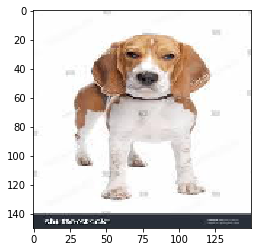

In [124]:
# %%time
for iloc in top_ix[:5]:
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None,
#             transform_dim=False
    #         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
        ).astype(np.uint8)
    )
    plt.figure()
    plt.imshow(np.asarray(im))
    
    
# im.show

# Query by image

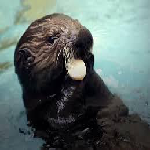

In [146]:
iloc = 21694
im = Image.fromarray(
    load_image(
        sample_data.iloc[iloc]['image'],
        size=None, 
#         transform_dim=False
#         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
    ).astype(np.uint8)
)
im
# plt.figure()
# plt.imshow(np.asarray(im))

In [147]:
image_query = ImageModel.predict(np.stack(sample_data.iloc[[iloc]].image_array.values))
res_im = cosine_similarity(image_embeddings, image_query)

In [148]:
top_im_ix = res_im[:, 0].argsort()[::-1][:10]
print(res_im[:, 0][top_im_ix])
print(top_im_ix)

[1.0000004  0.9509088  0.94668245 0.9380431  0.9379795  0.93471533
 0.93310386 0.9306387  0.92793775 0.92553556]
[21694 28737 24053 24096 18762 24152 28347 23983 23696 23764]


In [149]:
sample_data.iloc[top_im_ix]

,image,tokens,sequence,empty_sequence,image_array
21963,../../data/img_common_animals/otter/A0peqBT4iG...,"[sea, otter, live, web, cam, at, the, monterey...","[0, 0, 102, 86, 208, 582, 1620, 22, 1, 1813, 4...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.410511..."
29079,../../data/img_common_animals/macaque/VRe1bs_U...,"[lion, tailed, macaques, knights, of, the, rai...","[0, 33, 43, 315, 8793, 2, 1, 5163, 33, 43, 94,...",False,"[[[0.277524411678, 0.0, 0.320121467113, 0.0, 0..."
24330,../../data/img_common_animals/chimpanzee/KBjAV...,"[chimpanzee, nests, have, fewer, fecal, germs,...","[88, 3102, 104, 4678, 8030, 283, 314, 4107, 35...",False,"[[[0.599033594131, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
24373,../../data/img_common_animals/chimpanzee/WRVkN...,"[chimpanzee, disneynature, isha]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 2822]",False,"[[[0.211737126112, 0.0, 0.53711014986, 0.46566..."
19023,../../data/img_common_animals/primate/Cu-bWBuJ...,"[primate, animals, sioux, falls, sd, great, pl...","[0, 0, 0, 0, 0, 0, 0, 115, 45, 8396, 1417, 474...",False,"[[[0.317779928446, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
24429,../../data/img_common_animals/chimpanzee/tgI1B...,"[chimpanzee, disneynature, freddy]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 2822]",False,"[[[0.0, 0.0, 0.206220924854, 0.00935260951519,..."
28683,../../data/img_common_animals/macaque/EJ8ViRjg...,"[japanese, macaque, at, the, central, park, zo...","[0, 0, 0, 0, 0, 0, 374, 94, 22, 1, 817, 98, 34...",False,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
24260,../../data/img_common_animals/chimpanzee/UU2ig...,"[image, yes, they, re, conscious, chimpanzee, ...","[0, 0, 0, 0, 42, 2114, 112, 436, 8888, 88, 863...",False,"[[[0.301936209202, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
23973,../../data/img_common_animals/chimpanzee/cdRZ7...,"[disneynature, chimpanzee, 2012, rotten, tomat...","[0, 0, 0, 0, 0, 0, 0, 0, 2822, 88, 1712, 6388,...",False,"[[[0.390881836414, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
24041,../../data/img_common_animals/chimpanzee/jnx4Y...,"[chimpanzees, know, which, tool, will, be, eff...","[223, 149, 271, 2386, 203, 105, 2169, 7512, 88...",False,"[[[0.290941864252, 0.0, 1.60558342934, 0.0, 0...."


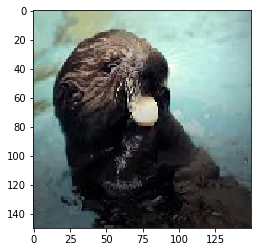

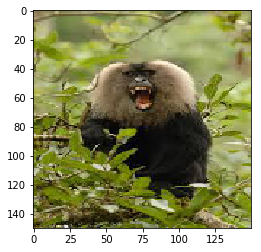

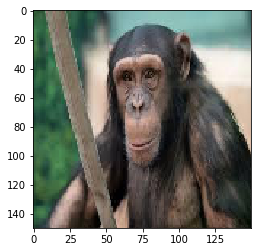

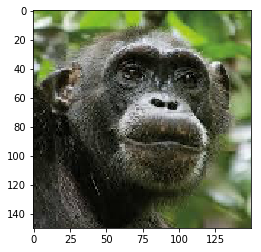

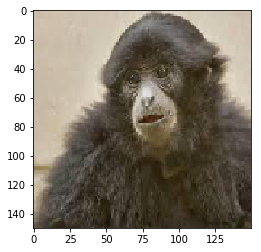

In [150]:
# %%time
for iloc in top_im_ix[:5]:
    im = Image.fromarray(
        load_image(
            sample_data.iloc[iloc]['image'],
            size=None, 
#             transform_dim=False
    #         '../../data/img/physics/jT6AxO5im1R5zM:.jpeg'
        ).astype(np.uint8)
    )
    plt.figure()
    plt.imshow(np.asarray(im))
    
    
# im.show

In [156]:
np.array([sample_data.loc[700].image_array]).shape #values.asarray()

(1, 4, 4, 512)

In [162]:
np.stack(sample_data.loc[[700]].image_array.values).shape

(1, 4, 4, 512)

In [348]:
im = imread('../../data/img/phone/UxhcE10enW7OeM:.png')

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [306]:
sample_data.iloc[9898]

image                   ../../data/img/phone/UxhcE10enW7OeM:.png
tokens         [cell, cellphone, phone, free, vector, graphic...
sequence       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
image_array    [[[0.0591950416565, 0.0, 0.0, 0.0191860049963,...
Name: 1761, dtype: object

In [308]:
full_data_df.iloc[9898]['image_link']

u'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcREnp_9QOWYxK5irRyhYpGztZtrnBgRDTitn7CsuNdLyEID0SJz'

In [42]:
record = sample_data.loc[3]

In [43]:
print record['caption'].lower()
print record['title'].lower()

caring for cats in cold weather - grey and white cat close up
caring for cats in cold weather - argos pet insurance


In [ ]:
EmbeddingModel = keras.models.Model(inputs=[text_model_input], outputs=[text_model_input])